In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
!pip install 'h5py<3.0.0'

In [4]:
from google.colab import files
uploaded = files.upload()

Saving pediatric pneumonia dataset_resized_150_150.zip to pediatric pneumonia dataset_resized_150_150.zip


In [5]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
from keras.datasets import cifar10
import os
import tensorflow as tf
import keras.backend as k
from keras.applications.vgg16 import VGG16
from keras.engine import Model
from keras import optimizers
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

Using TensorFlow backend.


In [6]:
image_height = 150
image_width = 150
batch_size = 8
no_of_epochs  = 100
number_of_training_samples=5216
number_of_validation_samples=16
number_of_test_samples=624

In [7]:
!unzip 'pediatric pneumonia dataset_resized_150_150.zip'

Streaming output truncated to the last 5000 lines.
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1210.jpeg  
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1211.jpeg  
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1212.jpeg  
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1213.jpeg  
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1214.jpeg  
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1215.jpeg  
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1216.jpeg  
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1217.jpeg  
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1218.jpeg  
  inflating: pediatric pneumonia dataset_resized_150_150/train/NORMAL/train_normal1219.jpeg  
  inflati

In [8]:
resized_images_150_150_train_dir='/content/pediatric pneumonia dataset_resized_150_150/train'
resized_images_150_150_test_dir='/content/pediatric pneumonia dataset_resized_150_150/test'
resized_images_150_150_validation_dir='/content/pediatric pneumonia dataset_resized_150_150/val'

In [9]:
import cv2
img = cv2.imread('/content/pediatric pneumonia dataset_resized_150_150/val/NORMAL/val_normal1.jpeg')
height, width, channels = img.shape
print(height, width, channels)

150 150 3


In [10]:
def adapt_classifier(base_model, train_all_layers=False):
    """
    This method builds the model for the fine tuning process, based on the base_model
    :param base_model:         model we want to fine tune
    :param train_all_layers:   whether we only want to train the fully connected layers

    :return model:             compiled model architecture
    """

    # build architecture
    inputs = keras.Input(shape=(150,150,3))
    #x = keras.layers.UpSampling2D()(inputs)
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    pred = Dense(2, activation='softmax')(x)

    #build model
    model = Model(inputs, pred)

    # set layers of base model to train_all_layers
    for layer in base_model.layers:
        layer.trainable = train_all_layers

    # compile with Adam and learning rate 0.001
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])
    return model

def fine_tune(model, batch_size):
    """
    This method actually calls the fit method of the model we pass
    :param model:          model we want to train
    :param x_train:        train data x
    :param y_train:        train labels y
    :param x_test:         test/validation data
    :param y_test:         test/validation labels
    :param batch_size:     Batch size during training

    :return history:       train statistics
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)
    
    validation_datagen=ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        resized_images_150_150_train_dir,
        target_size=(150, 150),
        batch_size=batch_size)

    validation_generator = validation_datagen.flow_from_directory(
        resized_images_150_150_validation_dir,
        target_size=(150, 150),
        batch_size=batch_size, shuffle=False)

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(number_of_training_samples//batch_size),
        epochs=100,
        validation_data=validation_generator,
        validation_steps=math.ceil(number_of_validation_samples//batch_size))

    return history

In [11]:
# build the model
model = adapt_classifier(VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)      

In [ ]:
# get the training statistics
history = fine_tune(model, 8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.

Epoch 1/100
652/652 [==============================] - 58s 88ms/step - loss: 0.2879 - accuracy: 0.8714 - val_loss: 0.0637 - val_accuracy: 0.8750
Epoch 2/100
652/652 [==============================] - 52s 79ms/step - loss: 0.2152 - accuracy: 0.9130 - val_loss: 0.0567 - val_accuracy: 0.8750
Epoch 3/100
652/652 [==============================] - 51s 78ms/step - loss: 0.1874 - accuracy: 0.9260 - val_loss: 0.0221 - val_accuracy: 0.8125
Epoch 4/100
652/652 [==============================] - 52s 79ms/step - loss: 0.1835 - accuracy: 0.9273 - val_loss: 0.0841 - val_accuracy: 0.8125
Epoch 5/100
652/652 [==============================] - 51s 78ms/step - loss: 0.1749 - accuracy: 0.9360 - val_loss: 0.0572 - val_accuracy: 0.8750
Epoch 6/100
652/652 [==============================] - 51s 78ms/step - loss: 0.1673 - accuracy: 0.9358 - val_loss: 0.0445 - val_accuracy: 0.8125
Epoch 7/100
652/652 [==========================

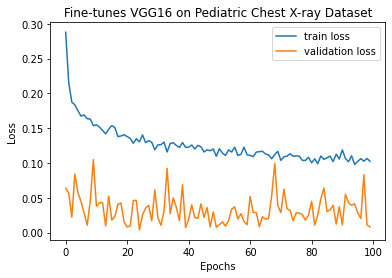

In [ ]:
# define figure
plt.title("Fine-tunes VGG16 on Pediatric Chest X-ray Dataset")
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
from google.colab import files
uploaded = files.upload()

Saving vgg16_pediatric cxr dataset_last 2 conv blocks frozen.h5 to vgg16_pediatric cxr dataset_last 2 conv blocks frozen.h5


In [13]:
import glob
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import cv2

normal_dir = Path('/content/pediatric pneumonia dataset_resized_150_150/train/NORMAL')
pneumonia_dir = Path('/content/pediatric pneumonia dataset_resized_150_150/train/PNEUMONIA')

normal_cases = normal_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_dir.glob('*.jpeg')

train_data = []
train_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    train_data.append(img)
    train_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    train_data.append(img)
    train_labels.append(label)

train_data = np.array(train_data)
train_labels = np.array(train_labels)
train_labels_one_hot_encoding=to_categorical(train_labels)

print("Total number and shape of train examples: ", train_data.shape)
print("Total number and shape of train labels:", train_labels.shape)

Total number and shape of train examples:  (5216, 150, 150, 3)
Total number and shape of train labels: (5216, 1)


In [14]:
normal_dir = Path('/content/pediatric pneumonia dataset_resized_150_150/test/NORMAL')
pneumonia_dir = Path('/content/pediatric pneumonia dataset_resized_150_150/test/PNEUMONIA')

normal_cases = normal_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_labels_one_hot_encoding=to_categorical(test_labels)

print("Total number and shape of test examples: ", test_data.shape)
print("Total number and shape of test labels:", test_labels.shape)

Total number and shape of test examples:  (624, 150, 150, 3)
Total number and shape of test labels: (624, 1)


In [15]:
normal_dir = Path('/content/pediatric pneumonia dataset_resized_150_150/val/NORMAL')
pneumonia_dir = Path('/content/pediatric pneumonia dataset_resized_150_150/val/PNEUMONIA')

normal_cases = normal_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_dir.glob('*.jpeg')

val_data = []
val_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    val_data.append(img)
    val_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    val_data.append(img)
    val_labels.append(label)

val_data = np.array(val_data)
val_labels = np.array(val_labels)
val_labels_one_hot_encoding=to_categorical(val_labels)

print("Total number and shape of validation examples: ", val_data.shape)
print("Total number and shape of validation labels:", val_labels.shape)

Total number and shape of validation examples:  (16, 150, 150, 3)
Total number and shape of validation labels: (16, 1)


In [ ]:
# save model
save_dir = 'final_models'
model_name = 'vgg16_pediatric cxr dataset_last 2 conv blocks frozen.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

In [16]:
# define class labels and number of classes
class_list = ["normal", "pneumonia"]
num_classes = 2

# define width, height and dimension of images
w, h, d = 150, 150, 3

x_train=train_data
y_train=train_labels_one_hot_encoding

x_test=test_data
y_test=test_labels_one_hot_encoding

x_val=val_data
y_val=val_labels_one_hot_encoding

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

x_train shape: (5216, 150, 150, 3)
5216 train samples
624 test samples
16 validation samples


In [17]:
model=load_model('vgg16_pediatric cxr dataset_last 2 conv blocks frozen.h5')

In [18]:
print(f"Model accuracy on train data: {model.evaluate(x_train, y_train)[1]}")
print(f"Model accuracy on test test: {model.evaluate(x_test, y_test)[1]}")

5216/5216 [==============================] - 32s 6ms/step
Model accuracy on train data: 0.9612730145454407
624/624 [==============================] - 4s 6ms/step
Model accuracy on test test: 0.9038461446762085


In [19]:
from keras.callbacks import ModelCheckpoint

In [20]:
def adapt_classifier_further(model):
    """
    This method builds the model for further fine tuning i.e. fine tune the last two convolutional blocks
    :param model:         model we want to fine tune
    
    :return model:             compiled model architecture
    """

    model.trainable = True

    set_trainable = False
    for layer in model.layers:
      if layer.name == 'vgg16':
        conv_base=layer
        for layer in conv_base.layers:
          if layer.name == 'block4_conv1':
            set_trainable = True
          if set_trainable:
            layer.trainable = True

    # compile with Adam and learning rate 0.001
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])
    return model

def fine_tune_last_two_conv_blocks(model, batch_size):
    """
    This method actually calls the fit method of the model we pass
    :param model:          model we want to train
    :param x_train:        train data x
    :param y_train:        train labels y
    :param x_test:         test/validation data
    :param y_test:         test/validation labels
    :param batch_size:     Batch size during training

    :return history:       train statistics
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)
    
    validation_datagen=ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        resized_images_150_150_train_dir,
        target_size=(150, 150),
        batch_size=batch_size)

    validation_generator = validation_datagen.flow_from_directory(
        resized_images_150_150_validation_dir,
        target_size=(150, 150),
        batch_size=batch_size, shuffle=False)

    filepath="VGG16_pediatric cxr dataset_Last_Two_Conv_Blocks_Fine_Tuned.h5"
    checkpoint = ModelCheckpoint(filepath, save_best_only=True)
    callbacks_list = [checkpoint]

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(number_of_training_samples//batch_size),
        epochs=75,
        callbacks=callbacks_list,
        validation_data=validation_generator,
        validation_steps=math.ceil(number_of_validation_samples//batch_size))

    return history

In [21]:
# build the model
fine_tuned_model = adapt_classifier_further(model)
history = fine_tune_last_two_conv_blocks(fine_tuned_model, 8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/75
652/652 [==============================] - 81s 124ms/step - loss: 0.3200 - accuracy: 0.8765 - val_loss: 0.0146 - val_accuracy: 0.6250
Epoch 2/75
652/652 [==============================] - 79s 122ms/step - loss: 0.2358 - accuracy: 0.9053 - val_loss: 0.1228 - val_accuracy: 0.6875
Epoch 3/75
652/652 [==============================] - 79s 122ms/step - loss: 0.1849 - accuracy: 0.9258 - val_loss: 0.4213 - val_accuracy: 0.7500
Epoch 4/75
652/652 [==============================] - 80s 122ms/step - loss: 0.1597 - accuracy: 0.9440 - val_loss: 0.4775 - val_accuracy: 0.8125
Epoch 5/75
652/652 [==============================] - 80s 122ms/step - loss: 0.1368 - accuracy: 0.9479 - val_loss: 0.0151 - val_accuracy: 0.7500
Epoch 6/75
652/652 [==============================] - 80s 122ms/step - loss: 0.1413 - accuracy: 0.9502 - val_loss: 0.1357 - val_accuracy: 0.6875
Epoch 7/75
652/652 [============================

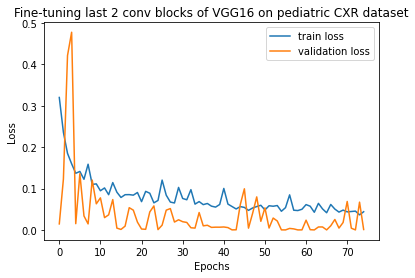

In [22]:
# define figure
plt.title("Fine-tuning last 2 conv blocks of VGG16 on pediatric CXR dataset")
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
fine_tuned_model= load_model('VGG16_pediatric cxr dataset_Last_Two_Conv_Blocks_Fine_Tuned.h5')

In [24]:
print(f"Model accuracy on train data: {fine_tuned_model.evaluate(x_train, y_train)[1]}")
print(f"Model accuracy on test test: {fine_tuned_model.evaluate(x_test, y_test)[1]}")

5216/5216 [==============================] - 25s 5ms/step
Model accuracy on train data: 0.9743098020553589
624/624 [==============================] - 3s 5ms/step
Model accuracy on test test: 0.9246794581413269


In [25]:
# save model
save_dir = 'final_models'
model_name = 'VGG16_pediatric cxr dataset_Last_Two_Conv_Blocks_Fine_Tuned.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)